# Maybe do manual code example (no pymc) for a 3 team league if possible

# Process Fixture Data

In [121]:
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import numpy as np
import seaborn as sns

In [ ]:
## X_ij and Y_ij are the goals for home and away team respectively and independently

## X_ij ~ Po(alpha_i x beta_j x gamma),  Y_ij ~ Po(alpha_j x beta_i)

## i = home, j = away, alpha = strength of att, beta = weakness of def, gamma = home adv.

## want to estimate the parameters, so will need priors and likelihoods. We have an att and def rating for each team
## and then the home adv parameter (global) so for English prem that is 41 independent parameters to estimate

## Likelihood will just be poisson pmf with parameter as above

## What kinds of values will the parameters take? (Maher)

## Only include teams initially in the prem. i.e. newly promoted teams from first season discarded

## Maybe put more weight on recent results somehow?, i.e. when using data over several years more recent seasons
## have a bigger impact when predicting the foloowing season

## For Prior information Could Incorporate total wage bill / transfer window spending amount / manager points per game (ppm).
## All this data is available, and would likely need to be included /updated after each season

In [122]:
# Read in score data

data1 = pd.read_csv('2013-14.csv')
data2 = pd.read_csv('2014-15.csv')
data3 = pd.read_csv('2015-16.csv')
data4 = pd.read_csv('2016-17.csv')

In [123]:
# select relevant columns and merge
# note there are stats disregarded here that could be used as prior information going into the following season, i.e. if a team has been very unlucky the underlying stats
# could show this

df1 = data1[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df2 = data2[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df3 = data3[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df4 = data4[["HomeTeam", "AwayTeam", "FTHG", "FTAG"]]

df = pd.concat([df1, df2, df3, df4])

In [124]:
# alphabetical list of team names

team_names = sorted(data1['HomeTeam'].unique())

In [125]:
# only keep teams featuring in initial seasom

df = df[(df['HomeTeam'].isin(team_names)) & (df['AwayTeam'].isin(team_names))]

In [126]:
# convert to numerical values 0 = Arsenal etc.

df.loc[:, 'home_id'] = pd.Categorical(df['HomeTeam'], categories=team_names).codes
df.loc[:, 'away_id'] = pd.Categorical(df['AwayTeam'], categories=team_names).codes

In [127]:
df

,HomeTeam,AwayTeam,FTHG,FTAG,home_id,away_id
0,Arsenal,Aston Villa,1,3,0,1
1,Liverpool,Stoke,1,0,8,14
2,Norwich,Everton,2,2,12,5
3,Sunderland,Fulham,0,1,15,6
4,Swansea,Man United,1,4,16,10
...,...,...,...,...,...,...
372,Chelsea,Sunderland,5,1,3,15
373,Hull,Tottenham,1,7,7,17
376,Man United,Crystal Palace,2,0,10,4
377,Southampton,Stoke,0,1,13,14


# pyMC Model NB: without home advantage param

In [128]:
# For now, priors will be based on Maher MLE estimates but allow for alot of uncertainty,
# used parameter constraints so that sum(alphas) = sum(betas) (Maher)

with pm.Model() as model:
  alphas_raw = pm.Gamma("alphas_raw", alpha=3, beta=1/0.6, shape=20)
  alphas = pm.Deterministic("alphas", alphas_raw / pt.mean(alphas_raw))

  betas_raw = pm.Gamma("betas_raw", alpha=2.5, beta=1/0.5, shape=20)
  betas = pm.Deterministic("betas", betas_raw / pt.mean(betas_raw))

In [129]:
# define Po rates for home and away (no gamma as of yet)

with model:
    lambda_h = alphas[df["home_id"]] * betas[df["away_id"]]
    lambda_a = alphas[df["away_id"]] * betas[df["home_id"]]

In [130]:
# likelihood of the goals data

with model:
    home_obs = pm.Poisson("hobs", lambda_h, observed=df["FTHG"])
    away_obs = pm.Poisson("aobs", lambda_a, observed=df["FTAG"])

In [131]:
# for now, just use same sampling as first diss example

with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [144]:
alpha_samples = trace['alphas']
beta_samples = trace['betas']

In [133]:
team_names

['Arsenal',
 'Aston Villa',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Hull',
 'Liverpool',
 'Man City',
 'Man United',
 'Newcastle',
 'Norwich',
 'Southampton',
 'Stoke',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'West Brom',
 'West Ham']

In [134]:
# can get samples for each team (table positions from 1st season)

# 4th place Arsenal
arsenal_attack_samples = [teams[0] for teams in alpha_samples]
arsenal_defence_samples = [teams[0] for teams in beta_samples]

# 16th place Hull
hull_attack_samples = [teams[7] for teams in alpha_samples]
hull_defence_samples = [teams[7] for teams in beta_samples]

# 1st place ManC
mancity_attack_samples = [teams[9] for teams in alpha_samples]
mancity_defence_samples = [teams[9] for teams in beta_samples]

# 20th place Cardiff
cardiff_attack_samples = [teams[2] for teams in alpha_samples]
cardiff_defence_samples = [teams[2] for teams in beta_samples]



1.4285795430970119
0.8279260939989573


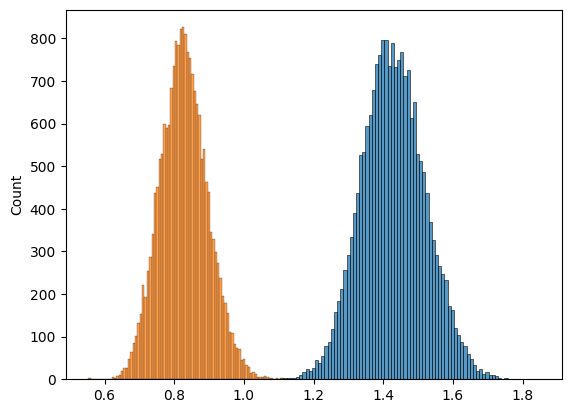

In [135]:
sns.histplot(arsenal_attack_samples)
print(np.mean(arsenal_attack_samples))
sns.histplot(arsenal_defence_samples)
print(np.mean(arsenal_defence_samples))

0.698951232622592
1.150842989931574


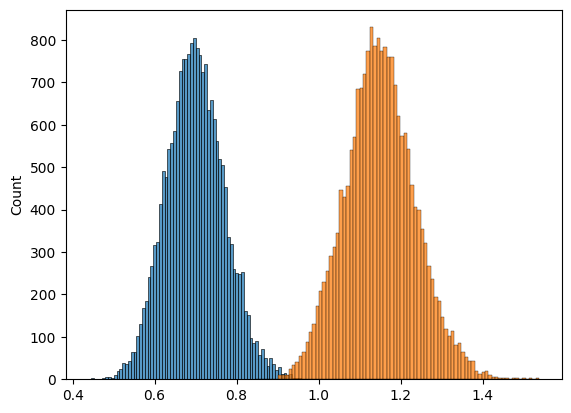

In [136]:
sns.histplot(hull_attack_samples)
print(np.mean(hull_attack_samples))
sns.histplot(hull_defence_samples)
print(np.mean(hull_defence_samples))

In [153]:
# Predict points tally for Team over the season

# Loop through each team that isn't Team and simulate 1 game between them and Team (Team at home), if Home>Away + 3 points, else, +0
# Times this point tally by 2, since home and away the same in this initial model

# function to predict points of 1 season based on a simulation of 5 games against each team

def predict_points(team_name):
  team_index = team_names.index(team_name)
  points = 0
  idxs = np.arange(20)
  idxs = np.delete(idxs, team_index)
  hometeam_attack_samples = [teams[team_index] for teams in alpha_samples]
  hometeam_defence_samples = [teams[team_index] for teams in beta_samples]
  for team in idxs:
      awayteam_attack_samples = [teams[team] for teams in alpha_samples]
      awayteam_defence_samples = [teams[team] for teams in beta_samples]
      x = 0
      y = 0
      for i in range(5):
         x += np.random.poisson(np.mean(hometeam_attack_samples)*np.mean(awayteam_defence_samples))
         y += np.random.poisson(np.mean(awayteam_attack_samples)*np.mean(hometeam_defence_samples))
      if x > y:
        points += 3
      else:
        points += 0

  return(2*points)



# function to do N simulations of the season and calculate an average for a team

def calc_avg_points(N, team):
  prediction = [0] * N
  for i in range(N):
    prediction[i] = predict_points(team)
  return(np.mean(prediction))

In [159]:
# Predict number of points for season 17-18, can compare to actual tally when model is more advanced

for team in ['Chelsea', 'Man City', 'Arsenal', 'Man United', 'Tottenham']:
  print(calc_avg_points(5, team))

94.8
93.6
85.2
74.4
72.0
